# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# PARTE PARTE: TEXT SUMMARIZATION

## I. Declaración de librerías

In [3]:
# Tratamiento de datos
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Tratamiento de texto
# ==============================================================================

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras import backend as K
#import tensorflow as tf

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuración matplotlib
# ==============================================================================
# Para obtener el estilo de plot de seabonr
plt.style.use('seaborn-whitegrid')
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"

# otras configuraciones
# ==============================================================================
#tqdm.pandas()
#pd.set_option("display.max_colwidth", 200)

#import os
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
#

In [4]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## II. Cargar y explorar el dataset

In [5]:
%%time
dataset_base = pd.read_csv("dataset_base.csv", sep='\t', encoding='utf-8')
dataset_base.sample(5)

CPU times: user 772 ms, sys: 55.6 ms, total: 828 ms
Wall time: 827 ms


,category,title,date,abstract,content,content_for_topic,content_for_summary,abstract_for_summary
55,ORGANISMO SUPERVISOR DE LA INVERSION EN INFRAE...,RESOLUCION N° 0037-2021-CD-OSITRAN,18/08/2021,Disponen el inicio de oficio del procedimiento...,"Lima, 13 de agosto de 2021 VISTOS: El Informe ...",lima agosto visto informe conjunto ositran fec...,lima agosto vistos informe conjunto ositran fe...,disponen inicio oficio procedimiento interpret...
2486,CORTES SUPERIORES DE JUSTICIA,RESOLUCION ADMINISTRATIVA N° 000181-2021-P-CS...,25/06/2021,Designan Responsables Titular y Alterno del Li...,Corte Superior Nacional de Justicia Penal Espe...,corte superior nacional justicia penal especia...,corte superior nacional justicia penal especia...,designan responsables titular alterno libro re...
1070,ENERGIA Y MINAS,RESOLUCION VICE MINISTERIAL N° 022-2021-MINEM...,23/07/2021,Aprueban el Procedimiento para ejecutar Proyec...,"Lima, 21 de julio de 2021 VISTOS: El Informe ...",lima julio visto informe minem fise dirección ...,lima julio vistos informe minem fise dirección...,aprueban procedimiento ejecutar proyectos entr...
475,PRODUCE,RESOLUCION MINISTERIAL N° 00221-2021-PRODUCE,04/08/2021,Designan Asesores II del Despacho Ministerial,"Lima, 3 de agosto de 2021 CONSIDERANDO: Que, s...",lima agosto encontrar vacante cargo asesor des...,lima agosto encuentra vacante cargo asesor des...,designan asesores despacho ministerial
2868,GOBIERNO REGIONAL DE HUANCAVELICA,ORDENANZA N° 458-GOB.REG.HVCA/CR,18/06/2021,Ordenanza Regional que incluye dos procedimien...,"Huancavelica, 21 de mayo del 2021. POR CUANTO ...",huancavelica mayo cuanto consejo regional huan...,huancavelica mayo cuanto consejo regional huan...,ordenanza regional incluye procedimientos admi...


___
Utilizar las columnas: 
* **content_for_summary**
* **abstract_for_summary**

Estas columnas a diferencia de **content_for_topic** son textos pre-procesados sin stemmer o lemmatizer. Es necesario mantener la palabras originales para ayudar a la red a mejorar la exactitud en la generación del "summary" 
___

In [6]:
# # Limpieza del dataset
# print("Dimensiones:", dataset_base.shape)
# print("Filas que no contiene valores nulos:", len(dataset_base[dataset_base.content_for_topic.notna()]))
# print("Filas con valores nulos:", len(dataset_base[dataset_base.isnull().any(axis=1)]))

Dimensiones: (4099, 8)
Filas que no contiene valores nulos: 4063
Filas con valores nulos: 36


In [7]:
# Eliminar registros que contienen valores nulos
dataset_base.dropna(inplace=True)
print("Dimensiones:", dataset_base.shape)

Dimensiones: (4063, 8)


In [8]:
# %%time
# # Eliminar registros que viene de una corrección, identificado como "errata"
# print("Filas con errata:", dataset_base[dataset_base.abstract_for_summary == "errata"].shape[0])

# # Eliminar las filas
# dataset_base.drop(dataset_base[dataset_base.abstract_for_summary == "errata"].index, inplace = True)
# print("Nuevas dimensiones:", dataset_base.shape)

Filas con errata: 52
Nuevas dimensiones: (4011, 8)
CPU times: user 3.45 ms, sys: 496 µs, total: 3.95 ms
Wall time: 3.04 ms


In [ ]:
print("Total de normas legales en el dataset:", dataset_base.shape[0])

___
Agregar la palablas (tokens) especiales al inicio y fin del abstract
___

In [9]:
%%time
# Función para marcar el texto que servira al Decoder del modelo Seq2Seq
dataset_base.abstract_for_summary = dataset_base.abstract_for_summary.apply(lambda t: "_START_ " + t + " _END_")
dataset_base.sample(5)

CPU times: user 4.04 ms, sys: 14 µs, total: 4.05 ms
Wall time: 3.58 ms


,category,title,date,abstract,content,content_for_topic,content_for_summary,abstract_for_summary,abstract_for_decoder
3642,ECONOMIA Y FINANZAS,RESOLUCION DIRECTORAL N° 0013-2021-EF/50.01,01/06/2021,Aprueban los Lineamientos para la presentación...,"Lima, 25 de mayo de 2021 CONSIDERANDO: Que, m...",lima mayo mediante numeral creer plan incentiv...,lima mayo mediante numeral crea plan incentivo...,aprueban lineamientos presentación propuestas ...,_START_ aprueban lineamientos presentación pro...
3256,ORGANISMO TÉCNICO DE LA ADMINISTRACIÓN DE LOS ...,RESOLUCION DIRECTORAL N° 000045-2021-OTASS-DE,09/06/2021,Designan Gerente General de la Empresa Municip...,"Lima, 9 de junio de 2021 VISTOS: El Informe Nº...",lima junio visto informe otass secretaría gest...,lima junio vistos informe otass secretaría ges...,designan gerente general empresa municipal agu...,_START_ designan gerente general empresa munic...
1615,INSTITUTO NACIONAL DE ESTADISTICA E INFORMATICA,RESOLUCION JEFATURAL N° 161-2021-INEI,14/07/2021,Autorizan la ejecución de la Encuesta Económic...,"Lima, 12 de julio de 2021 Visto el Oficio Nº 0...",lima julio visto oficio inei dnce dirección na...,lima julio visto oficio inei dnce dirección na...,autorizan ejecución encuesta económica anual n...,_START_ autorizan ejecución encuesta económica...
731,ORGANISMO TÉCNICO DE LA ADMINISTRACIÓN DE LOS ...,RESOLUCION N° 000077-2021-OTASS-DE,28/07/2021,Designan Gerente Comercial de la Empresa de Se...,"Lima, 27 de julio de 2021 VISTOS: El Proveído...",lima julio visto proveído otass dirección ejec...,lima julio vistos proveído otass dirección eje...,designan gerente comercial empresa servicio mu...,_START_ designan gerente comercial empresa ser...
2019,DESARROLLO AGRARIO Y RIEGO,RESOLUCION MINISTERIAL N° 0181-2021-MIDAGRI,03/07/2021,Designan representantes del Ministerio ante el...,"Lima, 1 de julio de 2021 CONSIDERANDO: Que, me...",lima julio mediante resolución ministerial mid...,lima julio mediante resolución ministerial mid...,designan representantes ministerio consejo dir...,_START_ designan representantes ministerio con...


___
Entender la distribución de las secuencias: anlizando el tamaño del contenido y el abstract. Este ejercicio ayuda a encontrar el tamaño máximo de las secuencias
___

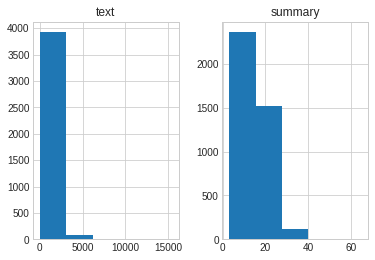

In [10]:
text_count = []
summary_count = []


for sent in dataset_base.content_for_summary:
    text_count.append(len(sent.split()))
for sent in dataset_base.abstract_for_summary:
    summary_count.append(len(sent.split()))

# Crear dataset para graficar histograma
graph_df = pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

plt.figure(figsize=(4,5))
graph_df.hist(bins = 30)
plt.show()

___
Asignamos número máximo de acuero a la gráfica, de tal manera que concentre la mayor parte de palabras y evitar los outliers
___

In [11]:
%%time
# El modelo realizará las siguientes secuencias: abstract/summary entre 1-max_summary_len tokens y para contenido/content entre 1 y max_content_len tokesn.
max_content_len=5000
max_summary_len=50

print("="*50)

# Verificar el porcentaje de palabras en el content entre 1 y max_content_len
print("% content de palabras entre 1 y " + str(max_content_len) + ":",
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.content_for_summary.split()) > 0 and
                       len(v.content_for_summary.split()) <= max_content_len, axis=1)
].shape[0]/len(dataset_base.content_for_summary)
)

# Verificar el porcentaje de palabras en el abstract entre 1 y max_summary_len
print("% abstract de palabras entre 1 y " + str(max_summary_len) + ":",
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.abstract_for_summary.split()) > 0 and
                       len(v.abstract_for_summary.split()) <= max_summary_len, axis=1)
].shape[0]/len(dataset_base.abstract_for_summary)
)

print("="*50)

% content de palabras entre 1 y 5000: 0.9930191972076788
% abstract de palabras entre 1 y 50: 0.9992520568436799
CPU times: user 444 ms, sys: 0 ns, total: 444 ms
Wall time: 442 ms


In [12]:
%%time
dataset_pre = \
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.content_for_summary.split()) > 0 and
                       len(v.content_for_summary.split()) <= max_content_len and
                       len(v.abstract_for_decoder.split()) > 0 and
                       len(v.abstract_for_decoder.split()) <= max_summary_len, axis=1)
][["content_for_summary","abstract_for_decoder"]]

dataset_pre.rename(columns={"content_for_summary":"content","abstract_for_decoder":"summary"}, inplace=True)
dataset_pre.sample(5)

CPU times: user 430 ms, sys: 0 ns, total: 430 ms
Wall time: 428 ms


,content,summary
3472,constitución política perú establece defensa p...,_START_ decreto supremo modifica reglamento ge...
851,lima julio vistos recurso apelación interpuest...,_START_ declaran infundado recurso apelación i...
1239,lima julio vistos oficio memorando memorando i...,_START_ designan miembro tribunal solución con...
3211,lima junio fortalecimiento comisión promoción ...,_START_ designan representantes gremios integr...
3315,yanacancha mayo alcalde municipalidad distrita...,_START_ aceptan donación inmueble otorgado com...


In [11]:
%%time
#Add sostok and eostok at 
dataset_pre.summary = dataset_pre.summary.apply(lambda v : "sostok " + v + " eostok")
dataset_pre.sample(2)

CPU times: user 5.05 ms, sys: 144 µs, total: 5.19 ms
Wall time: 4.77 ms


,content,summary
1769,congreso único declaración necesidad pública i...,sostok _START_ declara necesidad pública inter...
2066,lima julio antecedentes mediante resolución ad...,sostok _START_ declaran fundado recurso recons...


In [12]:
%%time
x_tr_i, x_val_i, y_tr_i, y_val_i = train_test_split(dataset_pre.content, dataset_pre.summary, test_size=0.1, random_state=0, shuffle=True)
x_tr_i.shape, x_val_i.shape

CPU times: user 4.23 ms, sys: 30 µs, total: 4.26 ms
Wall time: 3.64 ms


((3582,), (398,))

In [13]:
#from keras import backend as K
#from tensorflow.keras import backend as K



RARE WORD ANALYSIS FOR Y i.e 'summary'

    tot_cnt gives the size of vocabulary (which means every unique words in the text)

    cnt gives me the no. of rare words whose count falls below threshold

    tot_cnt - cnt gives me the top most common words



In [37]:
%%time
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(x_tr_i)

thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)
tot_cnt,cnt, tot_cnt-cnt, len(x_tokenizer.word_counts)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(x_tr_i)

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr_i) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val_i)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_content_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_content_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))
len(x_tokenizer.word_counts)

% of rare words in vocabulary: 41.938566915337034
Total Coverage of rare words: 0.8440977418155561
Size of vocabulary in X = 21871
CPU times: user 7.42 s, sys: 0 ns, total: 7.42 s
Wall time: 7.43 s


37667

In [15]:
%%time
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(y_tr_i)



thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(y_tr_i)

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr_i) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val_i) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 59.243986254295535
Total Coverage of rare words: 7.164159538557337
Size of vocabulary in Y = 2373
CPU times: user 775 ms, sys: 8.09 ms, total: 783 ms
Wall time: 779 ms


In [16]:
%%time
print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()


latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_content_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 21871
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 200)    4374200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 5000, 300),  601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [17]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [19]:
y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:].shape, y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:].shape, len([x_tr,y_tr[:,:-1]][1]), len([x_val,y_val[:,:-1]][1])

((398, 49, 1), (3582, 49, 1), 3582, 398)

In [22]:
%%time
history=model.fit(
    [x_tr,y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], 
    epochs=3, callbacks=[es], batch_size=16, 
    validation_data= ([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/3
224/224 [==============================] - 619s 3s/step - loss: 1.8338 - val_loss: 1.5607
Epoch 2/3
224/224 [==============================] - 641s 3s/step - loss: 1.5268 - val_loss: 1.4613
Epoch 3/3
224/224 [==============================] - 713s 3s/step - loss: 1.4050 - val_loss: 1.3607
CPU times: user 26min 22s, sys: 5min 23s, total: 31min 46s
Wall time: 32min 53s


### 

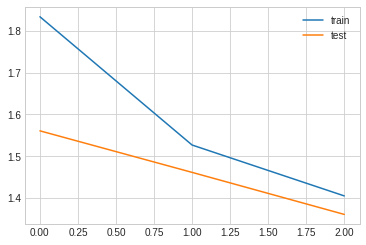

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [26]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [28]:
%%time
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_content_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [29]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [30]:

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [36]:
for i in range(25,30):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_content_len)))
    print("\n")

Review: chorrillos julio concejo municipal municipalidad distrital chorrillos vistos concejo municipal municipalidad distrital chorrillos sesión ordinaria fecha julio visto informe mdch fecha julio emitido gerencia administración tributaria memorándum mdch fecha julio emitido subgerencia fiscalización administrativa informe mdch fecha julio emitido subgerencia rentas memorándum mdch fecha julio emitido gerencia planeamiento presupuesto informe técnico mdch fecha julio emitido área funcional planeamiento institucional memorándum mdch fecha julio emitido subgerencia ejecutoría coactiva informe mdch fecha julio emitido subgerencia fiscalización tributaria informe mdch fecha julio emitido subgerencia obras privadas control urbano informe mdch fecha julio emitido subgerencia rentas informe mdch fecha julio emitido gerencia asesoría jurídica memorándum mdch fecha julio emitido gerencia municipal establecido constitución política perú modificado municipalidades provinciales distritales órgano